In [1]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, SymLogNorm, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import find_peaks, savgol_filter
from scipy.stats import iqr
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from sympy import Matrix, lambdify, linsolve, symbols
from warnings import warn
from os import listdir
from os.path import join
import itertools

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model
from module_update_phycobilisomes import add_OCP

from functions_custom_steady_state_simulator import simulate_to_steady_state_custom, _find_steady_state, get_response_coefficients, get_response_coefficients_array, get_response_coefficients_df, calculate_ss_Q_red, get_steadystate_y0

In [2]:
m, y0 = get_model(verbose=False, check_consistency=False)
m=fnc.add_exchange(m)
s = Simulator(m)

intensities = np.linspace(80, 800, 10)
wavelengths = [405, 440, 480, 550, 590, 624, 674]

for intens, wl in itertools.product(intensities, wavelengths):
    s.initialise(y0)
    s.update_parameter("pfd", lip.light_gaussianLED(wl, intens))

    s,t,y = simulate_to_steady_state_custom(
        s,         
        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        print(f"failed: {wl, intens}")

steady state not reached
CBBa   -2.681127e-12
PSII    1.345519e-08
OCP     0.000000e+00
dtype: float64
failed: (550, 800.0)


In [57]:
m, y0 = get_model(verbose=False, check_consistency=False)
m=fnc.add_exchange(m)
s = Simulator(m)

intensities = np.linspace(80, 800, 10)
wavelengths = [405, 440, 480, 550, 590, 624, 674]

sds = {}
for intens, wl in itertools.product(intensities, wavelengths):
    s.initialise(y0)
    s.update_parameter("pfd", lip.light_gaussianLED(wl, intens))

    s.simulate(1e6)

    res = s.get_full_results_df()
    rel = (res.apply(np.diff)) / (res.iloc[1:,:].reset_index().drop("index",axis=1))
    diff = rel.apply(np.linalg.norm,ord=2, axis=1)

    sds[(wl, intens)] = {
        cutoff: res.loc[diff[diff<=10.0**cutoff].index[0]:].std().mean() for cutoff in np.arange(-3,-9, -1)
    }


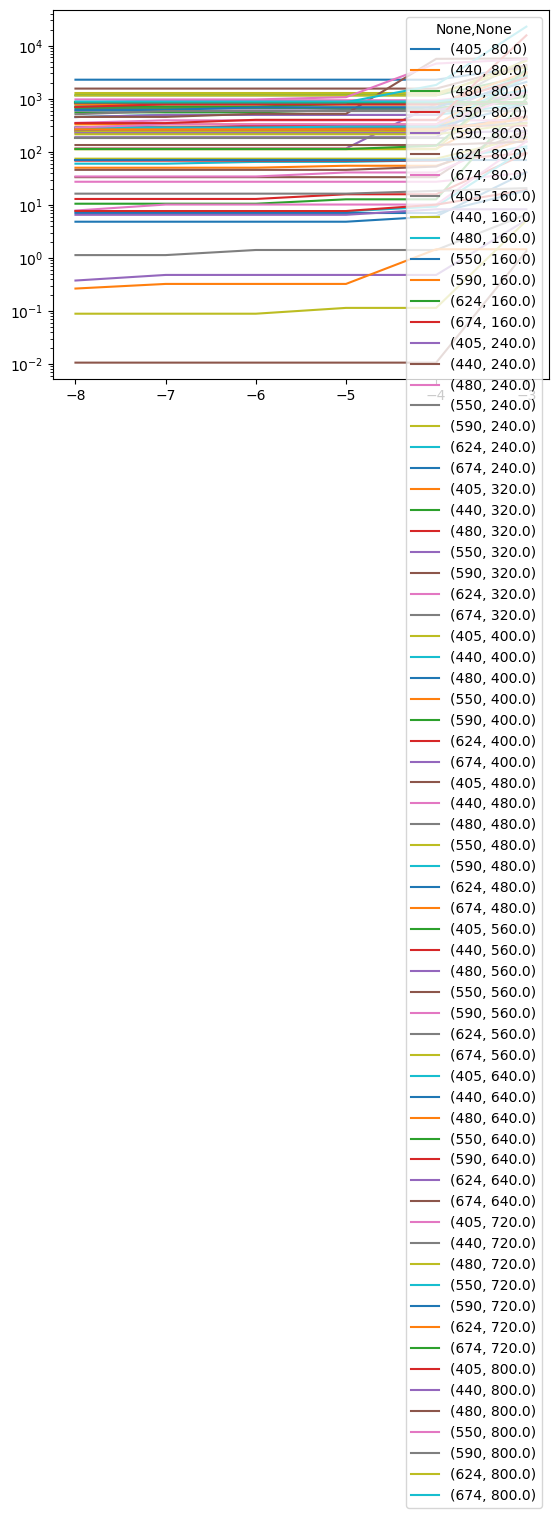

In [65]:
test = pd.DataFrame(sds)
ax = test.plot()
ax.set_yscale("log")

In [6]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

m_MCA.update_parameter("pfd", lip.light_gaussianLED(550, 800.0))

simulation_kwargs={
    "t_end": 1e6,
    "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
    "verbose": True,
}
rel_norm=True
parameters = ["PSItot"]

_ccc, _fcc = get_response_coefficients_df(
    m_MCA,
    parameters,
    y=y0,
    displacement=0.01,
    tolerance=None,
    disable_tqdm=True, 
    multiprocessing=False,
    rel_norm=rel_norm,
    simulation_kwargs=simulation_kwargs,
    **fnc.simulator_kwargs["loose"]
)

steady state not reached
CBBa   -2.681127e-12
PSII    1.345519e-08
OCP     0.000000e+00
dtype: float64


(<Figure size 1850x1050 with 4 Axes>,
 array([[<Axes: title={'center': 'ETC compounds'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>,
         <Axes: title={'center': 'O$_2$ and CO$_2$'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>],
        [<Axes: title={'center': 'pH of lumen and cytoplasm'}, xlabel='time [s]', ylabel='pH'>,
         <Axes: title={'center': 'CBB & PR compounds'}, xlabel='time [s]', ylabel='concentration [mmol mol(Chl)$^{-1}$]'>]],
       dtype=object))

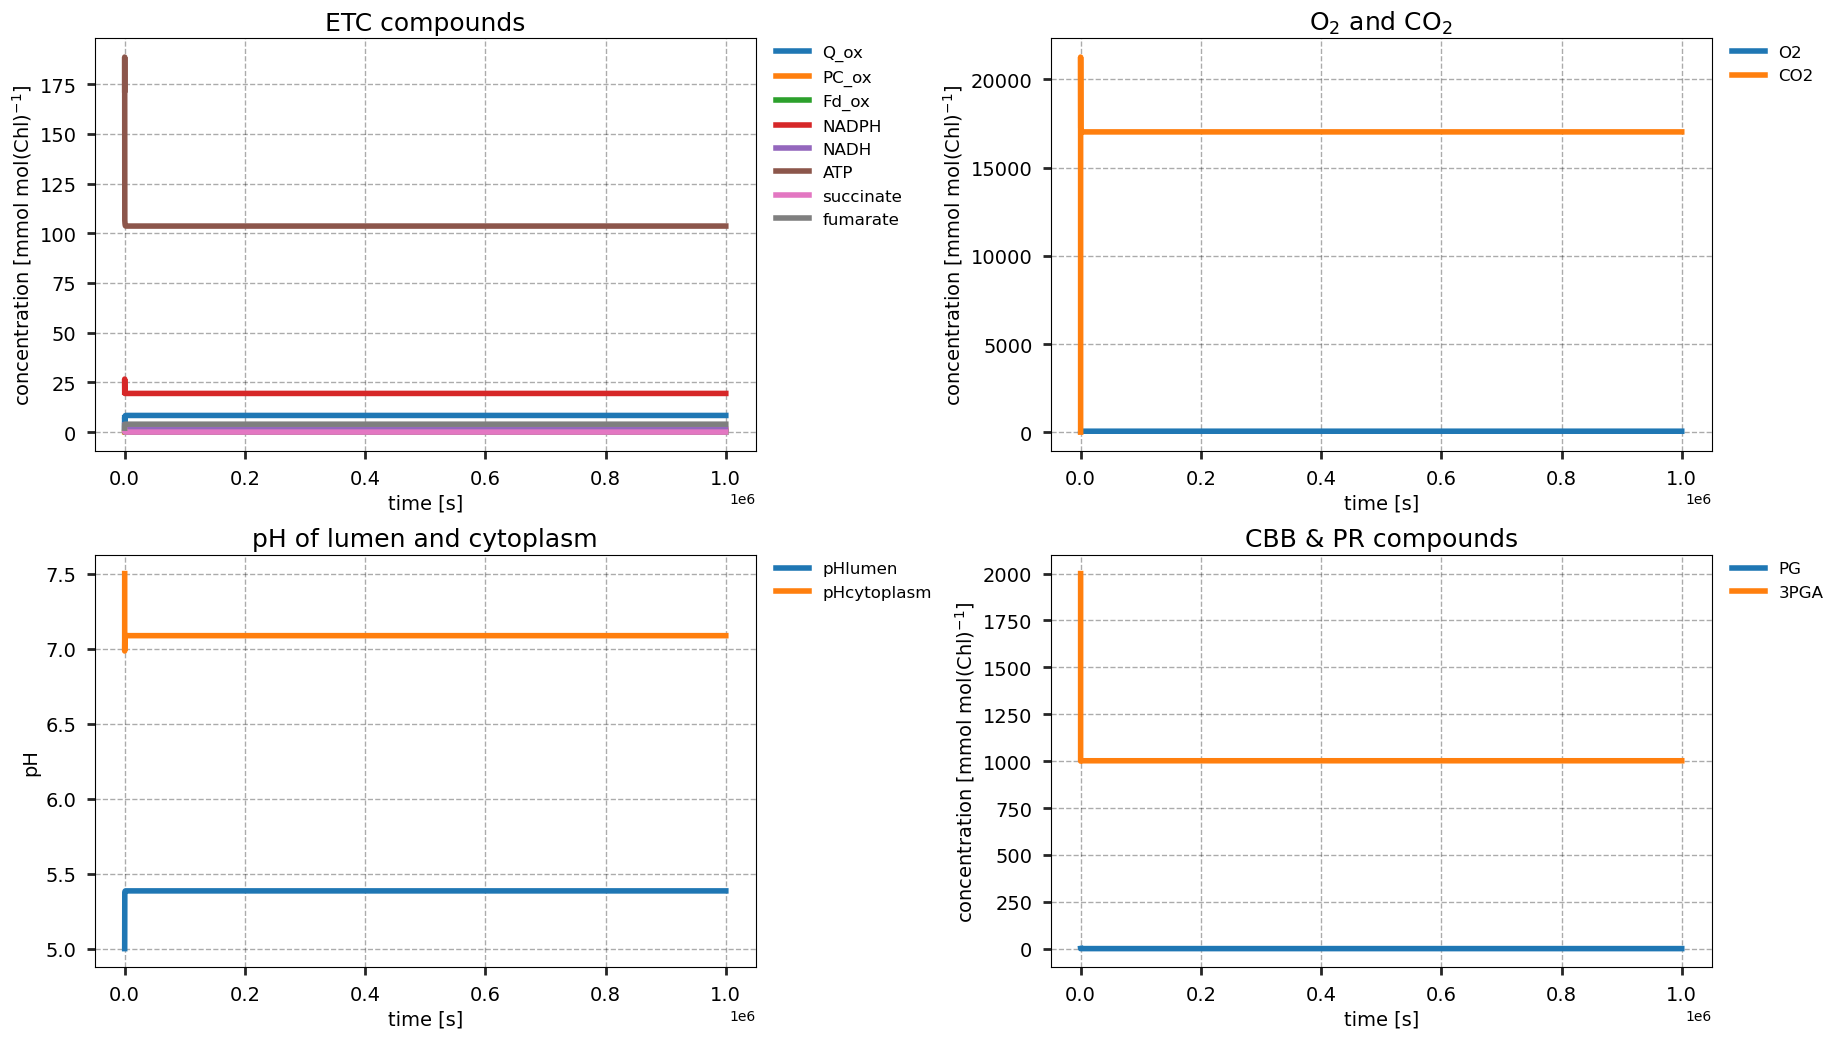

In [7]:
s = Simulator(m_MCA)
s.initialise(y0)
s.simulate(1e6)
fnc.plot_overview(s)

In [16]:
s = Simulator(m_MCA)
s.initialise(y0)
s.simulate(1e5)

# Calculate the relative change between integration points
res = s.get_full_results_df()
rel = (res.apply(np.diff)) / (res.iloc[1:,:].reset_index().drop("index",axis=1))
rel.index = res.index[1:]

In [26]:
(res/res.abs().max()).max()

PSII            1.000000
Q_ox            1.000000
Hi              1.000000
Ho              1.000000
O2              1.000000
                  ...   
dG_FNR         -0.017105
f_CBB_energy    1.000000
f_CBB_gas       1.000000
f_oxy_carbon    1.000000
f_oxy_gas       1.000000
Length: 62, dtype: float64

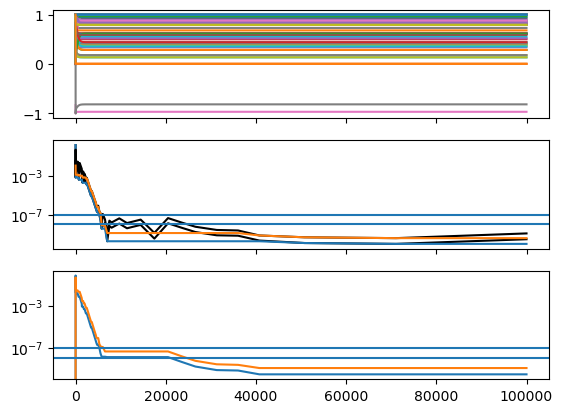

In [27]:
fig, axes  = plt.subplots(3,1, sharex=True)

axes[0].plot(res/res.abs().max())

for do_subset in [True, False]:
    if do_subset:
        _rel = rel.loc[:, ["CBBa", "PSII", "OCP"]]
        c="blue"
    else:
        _rel = rel.loc[:, [x for x in rel.columns if x not in ["CBBa", "PSII", "OCP"]]]
        c="green"
    diff = _rel.apply(np.linalg.norm,ord=2, axis=1)
    
    axes[1].plot(diff, c="k")

    # Plot the minimal differences
    mindiff = np.full(len(diff)+1, np.inf)
    for i in range(1,len(mindiff)):
        mindiff[i] = np.min([mindiff[i-1], diff.iloc[i-1]])

    mindiff = pd.Series(mindiff[1:], index=diff.index)
    axes[1].plot(mindiff)

    maxdiff = np.full(len(diff)+1, 0.0)
    for i in range(1,len(mindiff)):
        maxdiff[i] = np.max([maxdiff[i-1], diff.iloc[-i]])
    maxdiff = pd.Series(maxdiff[:0:-1], index=diff.index)
    axes[2].plot(maxdiff)



# axes[0].set_xscale("log")
for i in range(1,3):
    axes[i].set_yscale("log")
    axes[i].axhline(1e-7)
    axes[i].axhline(1e-8)



In [42]:
mindiff.loc[mindiff<1e-6]

4620.883077      8.867745e-07
4768.440617      5.957756e-07
5020.812187      5.957756e-07
5273.183757      2.085323e-07
5525.555328      1.350204e-07
5777.926898      7.973054e-09
6030.298468      7.973054e-09
6518.013612      7.973054e-09
7005.728756      1.240660e-09
7493.443900      1.240660e-09
7981.159043      1.240660e-09
9688.824322      1.240660e-09
11396.489601     1.240660e-09
14430.297793     1.240660e-09
17464.105985     1.240660e-09
20497.914177     1.240660e-09
23531.722368     1.240660e-09
26565.530560     1.240660e-09
31298.044246     1.240660e-09
36030.557932     1.240660e-09
40763.071617     6.973042e-10
50780.667428     4.526404e-10
71051.084375     3.706331e-10
100000.000000    3.706331e-10
dtype: float64

In [18]:
print(mindiff.loc[mindiff<1e-7].index[0])
print(mindiff.loc[mindiff<1e-8].index[0])

5777.926898038392
5777.926898038392


In [12]:
fig, ax = plt.subplots
ax = s.plot_selection("PSII")

TypeError: cannot unpack non-iterable function object

In [ ]:


s = Simulator(m)
s.initialise(y0)
s.simulate()